## Pairs Trading with Reversion Evaluation

In [62]:
%pylab inline

import warnings
import numpy as np
import pandas as pd
import datetime as dt

#The package now includes various advances, such as Value at Risk, Vector Autoregression, Vector Error Correction
import statsmodels.api as sm
import statsmodels.tsa.api as ts #or as ts. 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

from scipy import optimize
from IPython.display import Image
import pyfolio as pf


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Foreword on Backtesting with Quantopian

How do we know that a strategy/portfolio/single stock beats the market? Below is a simple backtest example on the directional 100% investment in Marriott International stock.

Start 2013-01-02, end 2018-06-25.

`cmd`  
`pip install pyfolio`  
CAUTION Pyfolio package likely require OLD VERSIONS of matplotlib and numpy (possibly entire pre Python 3.7 core) to run correct.

If things not working for you, turn to Quantopian IDE (website) for full backtesting capabilities and examples. You will need to register.

/home/msjithin/Stat_arb/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:666: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.137%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2010-11-19
End date,2018-06-25
Total months,91
,Backtest
Annual return,-1.137%
Cumulative returns,-8.306%
Annual volatility,25.759%
Sharpe ratio,0.09
Calmar ratio,-0.02
Stability,0.08
Max drawdown,-51.921%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,51.92,2011-01-27,2012-07-26,2014-07-16,905
1,32.97,2014-07-24,2016-02-11,NaT,NaN
2,4.97,2011-01-12,2011-01-20,2011-01-27,12
3,3.56,2010-11-19,2010-11-23,2010-12-01,9
4,2.26,2010-12-03,2010-12-14,2010-12-20,12


/home/msjithin/Stat_arb/.venv/lib/python3.9/site-packages/pyfolio/tears.py:1004: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn(


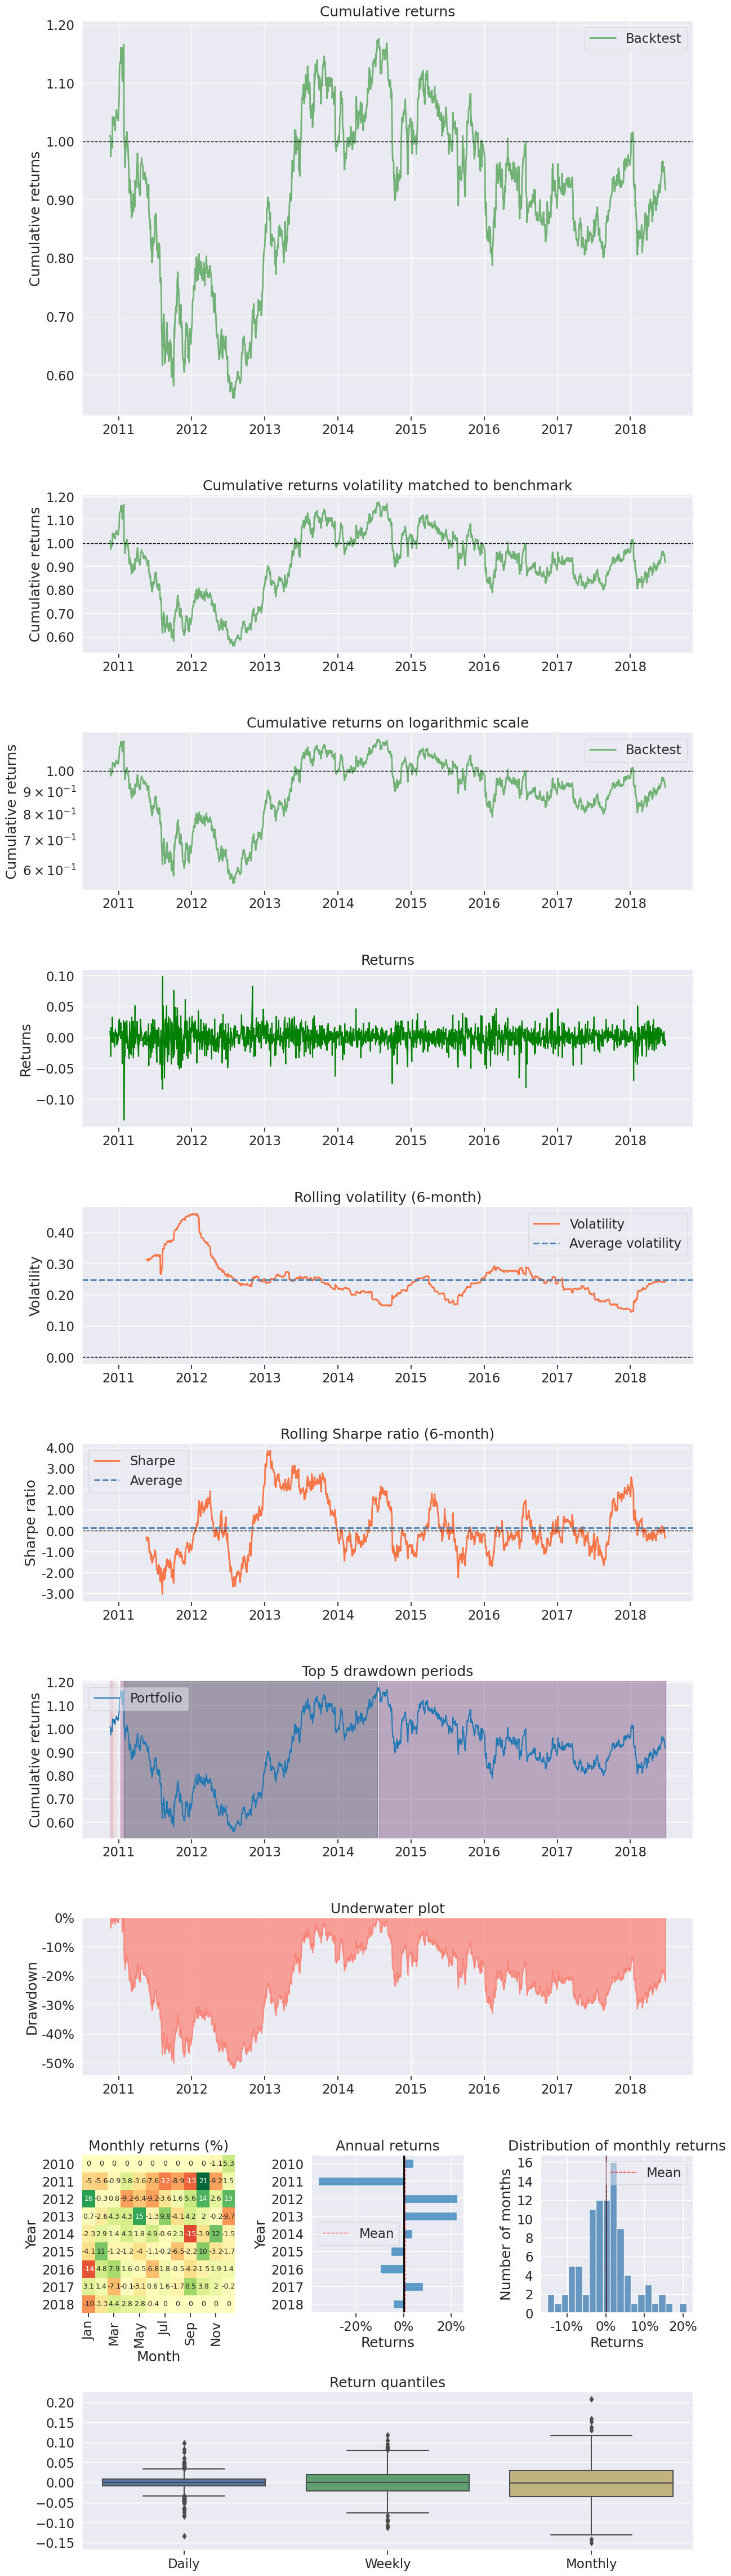

In [2]:
import pyfolio as pf

tickers = [['F', 'Ford'], ['GM', 'General Motors'], ['SPY', 'S&P 500']] 

cointprices = pd.read_excel('data/prices_coint_auto.xlsx', index_col=0)

returns = cointprices['Ford'].pct_change() 
returns.dropna(inplace=True)

pf.create_full_tear_sheet(returns) 

In [3]:
tickers_auto = [['F', 'Ford'], ['GM', 'General Motors'], ['SPY', 'S&P 500']] 

cointprices = pd.read_excel('data/prices_coint_auto.xlsx', index_col=0)
# cointprices.columns = [tickers_auto[0][0], tickers_auto[1][0], tickers_auto[2][0]] #rename columns to tickers
cointprices.head()

,Ford,General Motors,S&P 500
Date,,,
2010-11-18,12.541677,28.181452,102.562271
2010-11-19,12.666161,28.239155,102.844398
2010-11-22,12.603919,28.090796,102.758911
2010-11-23,12.214911,27.406654,101.271263
2010-11-24,12.409413,27.596235,102.767479


In [4]:
cointprices = cointprices[(cointprices.index > '2010-10-1') & (cointprices.index <= '2016-10-1')]

cointprices

,Ford,General Motors,S&P 500
Date,,,
2010-11-18,12.541677,28.181452,102.562271
2010-11-19,12.666161,28.239155,102.844398
2010-11-22,12.603919,28.090796,102.758911
2010-11-23,12.214911,27.406654,101.271263
2010-11-24,12.409413,27.596235,102.767479
...,...,...,...
2016-09-26,10.861752,29.345434,207.159378
2016-09-27,10.834618,29.160870,208.445404
2016-09-28,10.934101,29.437716,209.480042


In [5]:
cointprices.dtypes


Ford              float64
General Motors    float64
S&P 500           float64
dtype: object

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

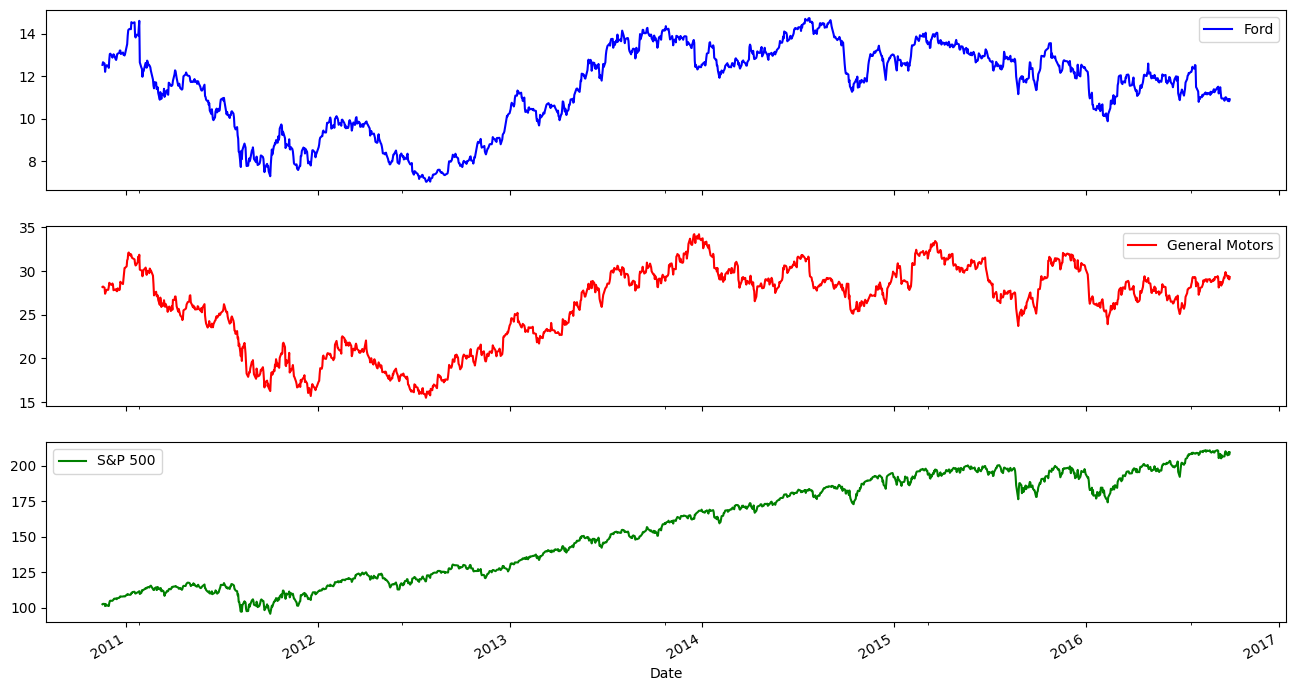

In [6]:
cointprices.plot(figsize=(16,9), color=('b', 'r', 'g'), subplots=True) 
#https://matplotlib.org/3.1.1/gallery/color/named_colors.html


<Axes: xlabel='Date'>

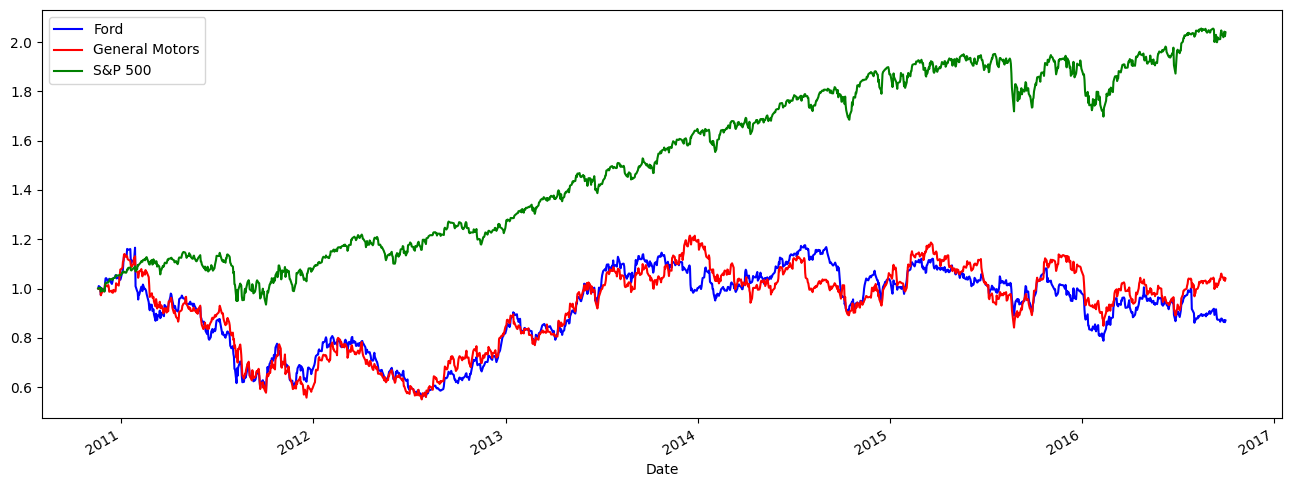

In [7]:
cointprices_1 = cointprices/cointprices.iloc[0]
cointprices_1.plot(figsize=(16,6), color=('b', 'r', 'g'))

Cointegration testing is sensitive to the initial value

Normalising to start at one -- also allows 1:1 comparison of P&L:

* Both, Ford and General Motors delivered about 0% average annual return -- if we look at the performance over these five-year period.
* S&P 500 index, on the other hand, delived an average annual return > 12%

## Daily Returns


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

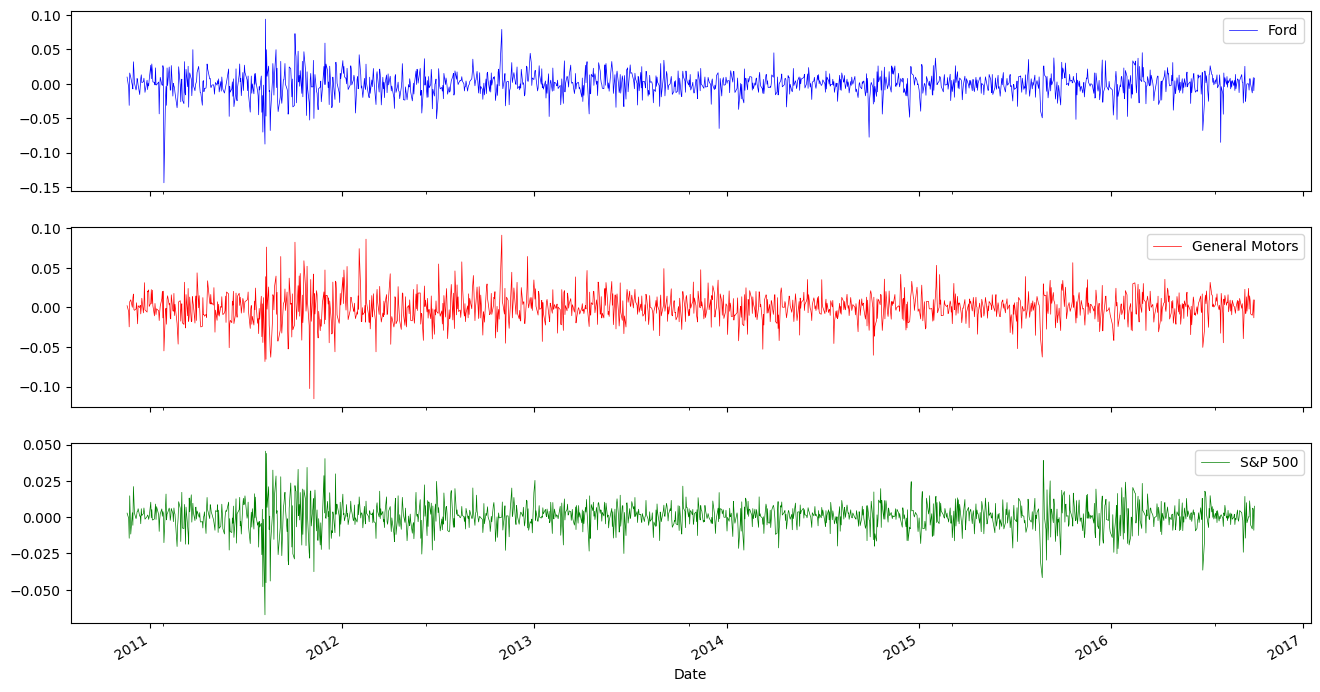

In [8]:
returns = np.log(cointprices).diff().dropna()
returns.plot(figsize=(16,9), color=('b', 'r', 'g'), subplots=True, linewidth=0.5)

In [42]:
def getdf_VARmodel(returns):
    # Convert DataFrame to numpy array
    data = returns.values

    # Create a VAR model instance
    model = VAR(data)

    # Fit the VAR model with lag order selection
    lag_order = model.select_order()

    # Fit the VAR model with selected lag order
    results = model.fit(lag_order.selected_orders['aic'])

    # Get the estimated coefficients
    coefficients = results.params

    # Get standard deviation of the estimates
    std_errors = results.stderr

    # Get t-statistics
    t_stats = coefficients / std_errors

    coefficients_df = pd.DataFrame(coefficients, 
                                   columns=returns.columns)
    std_errors_df = pd.DataFrame(std_errors, 
                                    columns=returns.columns)
    t_stats_df = pd.DataFrame(t_stats, 
                                    columns=returns.columns)
    
    # Add a MultiIndex to each DataFrame's columns
    coefficients_df.columns = pd.MultiIndex.from_product([['Coefficients'], coefficients_df.columns])
    std_errors_df.columns = pd.MultiIndex.from_product([['Standard Errors'], std_errors_df.columns])
    t_stats_df.columns = pd.MultiIndex.from_product([['T-Statistics'], t_stats_df.columns])

    # Concatenate the three DataFrames side by side
    combined_df = pd.concat([coefficients_df, std_errors_df, t_stats_df], axis=1)
    combined_df.index = ['Constant'] + [f'(Lag 1, {x})' for x in returns.columns]

    return combined_df

In [54]:
def getIC(returns, lag=1):
    # Convert DataFrame to numpy array
    data = returns.values

    # Create a VAR model instance
    model = VAR(data)

    # Fit the VAR model with selected lag order
    results = model.fit(lag)
    
    # Get AIC and BIC for lag 1
    aic_lag = results.aic
    bic_lag = results.bic

    return [aic_lag, bic_lag]

In [45]:
VAR_Demo = getdf_VARmodel(returns)
VAR_Demo

Coefficients                          Standard Errors  \
                                Ford General Motors   S&P 500            Ford   
Constant                   -0.000049       0.000031  0.000508        0.000448   
(Lag 1, Ford)               0.102431       0.059577  0.004979        0.041445   
(Lag 1, General Motors)    -0.005268      -0.018783  0.004345        0.036682   
(Lag 1, S&P 500)           -0.087447       0.000511 -0.056109        0.068361   

                                                 T-Statistics                 \
                        General Motors   S&P 500         Ford General Motors   
Constant                      0.000481  0.000250    -0.108667       0.065476   
(Lag 1, Ford)                 0.044499  0.023086     2.471511       1.338832   
(Lag 1, General Motors)       0.039385  0.020433    -0.143620      -0.476908   
(Lag 1, S&P 500)              0.073398  0.038079    -1.279192       0.006964   

                                   
                          S&P 500  
Constant                 2.037382  
(Lag 1, Ford)            0.215685  
(Lag 1, General Motors)  0.212667  
(Lag 1, S&P 500)        -1.473508

To investigate whether the daily returns depend on their past values, we fit the VAR(1) model to DAILY RETURNS (above, to be read column-wise)

The question now is whether the estimated coefficients are significantly different from zero. We inspect the  p
 -values. We will reject the hypothesis that a regression coefficient is zero if the corresponding  p
 -value is less than 5%.

In the table below TRUE indicates a regression coefficient that is SIGINIFICANTLY DIFFERENT from zero:

In [50]:
VAR_Demo['T-Statistics']>1.96 # pvalue<0.05


,Ford,General Motors,S&P 500
Constant,False,False,True
"(Lag 1, Ford)",True,False,False
"(Lag 1, General Motors)",False,False,False
"(Lag 1, S&P 500)",False,False,False


The outcome is not very promising.

To investigate and re-check if we should have included more past values in the model, we check Information Criteria (AIC, BIC) for the range  p=1,…,10

In [57]:
IC = pd.DataFrame([getIC(returns, p+1) for p in range(10)], 
                  index=[p+1 for p in range(10)],
                  columns=['AIC', 'BIC']
                  )
IC

,AIC,BIC
1,-26.908843,-26.865753
2,-26.899725,-26.824277
3,-26.902051,-26.794209
4,-26.897263,-26.756991
5,-26.904856,-26.732119
6,-26.893282,-26.688043
7,-26.884298,-26.646522
8,-26.876298,-26.605948
9,-26.872130,-26.569171
10,-26.860620,-26.525015


We select by the largest modulus (absolute value), in this case, optimal lag  p=1
  according to the both, AIC and BIC.

In [58]:
IC.idxmin()


AIC    1
BIC    1
dtype: int64

The above vignette analysis of returns can be concluded that past lagged values cannot be used to predict the future returns for these two equties.

Things can be different for market indicies and for over long-term, 15-30 years of daily data or even more, but that has limited applicability.

## Cointegration Analysis
The idea is that a linear combination of two non-stationary time series (say, each is Brownian Motion) results in the residual, which is not stationary. That is not guaranteed. More formally, we say that Prices are I(1) time series (nonstaionary), whereas their combination -- a residual from naive regression is I(0) time series, or stationary.

In this section we implement the Engle-Granger procedure to confirm (or not) if the pair is cointegrated and therefore, suitable for trade design.

We begin by recapping what the prices for Ford and General Motors from before look like:

## Engle-Granger Procedure

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

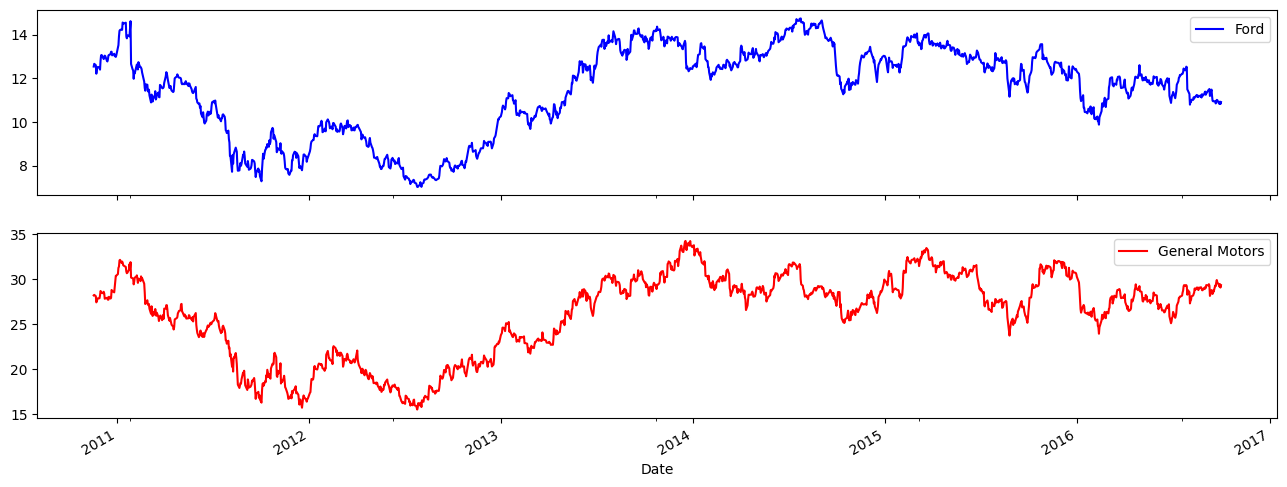

In [15]:
Price_B = cointprices.iloc[:, [1]] #GM stock price -- variable X
Price_A = cointprices.iloc[:, [0]] #Ford stock price -- variable Y

cointprices.iloc[:, [0,1]].plot(figsize=(16,6), color=('b', 'r'), subplots=True)

### ENGLE-GRANGER STEP 1. Cointegrated Residual (spread e_t)
We are now ready to perform the 1st step of the Engle-Granger procedure which is to estimate the model:

$$
\text{Ford}_t=β\text{GM}_t+μ_e+ϵ_t
$$
and so, our NAIVE cointegrated residual is
$$
e_t=\text{Ford}_t−0.4066\text{GM}_t−0.8682
 $$
Vector cointegrating weights can be fine-tuned by running the ready multivariate cointegration (VECM routines, such as cajorls in R package urca )
$$
β_\text{Coint}=[1,−0.4066]  
$$
$$
μ_e=−0.8682
$$

In [63]:
# Generate some example data
np.random.seed(0)
n = 100
t = np.arange(n)
x = np.random.normal(0, 1, n).cumsum()  # Non-stationary time series
y = 0.5 * x + np.random.normal(0, 1, n)  # Cointegrated time series

# Step 1: Estimate cointegrating relationship using OLS regression
# Add a constant to the independent variable (y)
x_with_const = sm.add_constant(x)
# Fit OLS regression model
model = sm.OLS(y, x_with_const)
results = model.fit()
# Extract parameters
beta_hat = results.params[1]
alpha_hat = results.params[0]

# Step 2: Check residuals for stationarity using ADF test
# Calculate residuals
residuals = y - beta_hat * x - alpha_hat
# Perform ADF test
adf_result = adfuller(residuals)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

# Print the estimated cointegrating relationship
print("Cointegrating relationship: y =", beta_hat, "* x +", alpha_hat)

ADF Statistic: -10.525168507978735
p-value: 9.458561326766795e-19
Critical Values: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}
Cointegrating relationship: y = 0.5450924825891463 * x + -0.16702405791590277
